In [176]:
import io

import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import gurobipy_pandas as gppd

gppd.set_interactive()

In [177]:
generator_data = pd.read_csv(io.StringIO("""
generator_class,num_available,min_output,max_output,cost_per_hour,marginal_cost,startup_cost,state0
thermal1,12,850.0,2000.0,1000.0,2.0,2000.0,12
thermal2,10,1250.0,1750.0,2600.0,1.30,1000.0,0
thermal3,5,1500.0,4000.0,3000.0,3.0,500.0,0
"""), index_col=0)
generator_data

,num_available,min_output,max_output,cost_per_hour,marginal_cost,startup_cost,state0
generator_class,,,,,,,
thermal1,12,850.0,2000.0,1000.0,2.0,2000.0,12
thermal2,10,1250.0,1750.0,2600.0,1.3,1000.0,0
thermal3,5,1500.0,4000.0,3000.0,3.0,500.0,0


In [178]:
# TODO - datetime?
demand = pd.read_csv(io.StringIO("""
time_period,demand
0_50_39,15000.0
1,30000.0
2,25000.0
3,40000.0
4,27000.0
""")).assign(time_period=pd.date_range(pd.Timestamp("2024-07-19 06:00:00"), freq="h", periods=5)).set_index("time_period")["demand"]
demand.to_frame()

,demand
time_period,
2024-07-19 06:00:00,15000.0
2024-07-19 07:00:00,30000.0
2024-07-19 08:00:00,25000.0
2024-07-19 09:00:00,40000.0
2024-07-19 10:00:00,27000.0


In [179]:
env = gp.Env()

In [180]:
model = gp.Model(env=env)

For each generator type, we have three classes of variables:
- The total output of all generators in the class in the given time period (continuous)
- The number of active generators of the class in the given time period (integer, upper bounded by number of available generators)
- The number of active generators of the class which start up in the given time period (integer)

In [181]:
# Method chain our way to creating these variable sets.
# We need to create a dense index: generators x time periods.

index_formatter = {"time_period": lambda index: index.strftime("%H%M")}

generators = (
    pd.DataFrame(index=pd.MultiIndex.from_product([generator_data.index, demand.index]))
    .join(generator_data)
    .gppd.add_vars(model, name="output", index_formatter=index_formatter)
    # Uses the data column to set the upper bound on the number of generators
    .gppd.add_vars(model, vtype=GRB.INTEGER, ub="num_available", name="num_active", index_formatter=index_formatter)
    .gppd.add_vars(model, vtype=GRB.INTEGER, name="num_startup", index_formatter=index_formatter)
)
generators

num_available  min_output  max_output  \
generator_class time_period                                                  
thermal1        2024-07-19 06:00:00             12       850.0      2000.0   
                2024-07-19 07:00:00             12       850.0      2000.0   
                2024-07-19 08:00:00             12       850.0      2000.0   
                2024-07-19 09:00:00             12       850.0      2000.0   
                2024-07-19 10:00:00             12       850.0      2000.0   
thermal2        2024-07-19 06:00:00             10      1250.0      1750.0   
                2024-07-19 07:00:00             10      1250.0      1750.0   
                2024-07-19 08:00:00             10      1250.0      1750.0   
                2024-07-19 09:00:00             10      1250.0      1750.0   
                2024-07-19 10:00:00             10      1250.0      1750.0   
thermal3        2024-07-19 06:00:00              5      1500.0      4000.0   
                2024-07-19 07:00:00              5      1500.0      4000.0   
                2024-07-19 08:00:00              5      1500.0      4000.0   
                2024-07-19 09:00:00              5      1500.0      4000.0   
                2024-07-19 10:00:00              5      1500.0      4000.0   

                                     cost_per_hour  marginal_cost  \
generator_class time_period                                         
thermal1        2024-07-19 06:00:00         1000.0            2.0   
                2024-07-19 07:00:00         1000.0            2.0   
                2024-07-19 08:00:00         1000.0            2.0   
                2024-07-19 09:00:00         1000.0            2.0   
                2024-07-19 10:00:00         1000.0            2.0   
thermal2        2024-07-19 06:00:00         2600.0            1.3   
                2024-07-19 07:00:00         2600.0            1.3   
                2024-07-19 08:00:00         2600.0            1.3   
                2024-07-19 09:00:00         2600.0            1.3   
                2024-07-19 10:00:00         2600.0            1.3   
thermal3        2024-07-19 06:00:00         3000.0            3.0   
                2024-07-19 07:00:00         3000.0            3.0   
                2024-07-19 08:00:00         3000.0            3.0   
                2024-07-19 09:00:00         3000.0            3.0   
                2024-07-19 10:00:00         3000.0            3.0   

                                     startup_cost  state0  \
generator_class time_period                                 
thermal1        2024-07-19 06:00:00        2000.0      12   
                2024-07-19 07:00:00        2000.0      12   
                2024-07-19 08:00:00        2000.0      12   
                2024-07-19 09:00:00        2000.0      12   
                2024-07-19 10:00:00        2000.0      12   
thermal2        2024-07-19 06:00:00        1000.0       0   
                2024-07-19 07:00:00        1000.0       0   
                2024-07-19 08:00:00        1000.0       0   
                2024-07-19 09:00:00        1000.0       0   
                2024-07-19 10:00:00        1000.0       0   
thermal3        2024-07-19 06:00:00         500.0       0   
                2024-07-19 07:00:00         500.0       0   
                2024-07-19 08:00:00         500.0       0   
                2024-07-19 09:00:00         500.0       0   
                2024-07-19 10:00:00         500.0       0   

                                                                 output  \
generator_class time_period                                               
thermal1        2024-07-19 06:00:00  <gurobi.Var output[thermal1,0600]>   
                2024-07-19 07:00:00  <gurobi.Var output[thermal1,0700]>   
                2024-07-19 08:00:00  <gurobi.Var output[thermal1,0800]>   
                2024-07-19 09:00:00  <gurobi.Var output[thermal1,0900]>   
                2024-07-19 10:00:00  <gurobi.Var

In [182]:
# Generation constraints

# Predicted demand is exactly satisfied
demand_constraint = gppd.add_constrs(
    model,
    generators.groupby("time_period")["output"].sum(),
    GRB.EQUAL,
    demand,
)

gppd.add_constrs(
    model,
    generators["output"],
    GRB.GREATER_EQUAL,
    generators["min_output"] * generators["num_active"],
    
)

# The started generators during each time period can serve 115% of predicted demand.
max_capacity = (generators["max_output"] * generators["num_active"]).groupby("time_period").sum()
max_capacity_constraint = gppd.add_constrs(
    model,
    demand * 1.15,
    GRB.LESS_EQUAL,
    max_capacity,
)

In [183]:
# Generation cost in each time period

total_generation_costs = (
    # Fixed hourly costs for started generators
    generators["cost_per_hour"] * generators["num_active"]
    # Marginal hourly cost of additional generation above the minimum
    + generators["marginal_cost"] * (
        generators["output"]
        - generators["num_active"] * generators["min_output"]
    )
).sum()

In [184]:
# Startup cost; for this we need to first constrain the relationship
# between active generators and startups

def startup_constraints(group):
    group = group.sort_index()
    return gppd.add_constrs(
        model,
        group["num_startup"].iloc[1:],
        GRB.GREATER_EQUAL,
        (group["num_active"] - group["num_active"].shift(1)).dropna(),
        name="startup",
    ).to_frame()

startup = generators.groupby("generator_class").apply(startup_constraints).droplevel(0)

# for key, entry in startup['startup'].items():
#     print(model.getRow(entry), entry.sense, entry.rhs)

# Startup costs compared to initial state

time_period_1 = generators.sort_index().groupby("generator_class").first()
initial_startup = gppd.add_constrs(
    model,
    time_period_1["num_startup"],
    GRB.GREATER_EQUAL,
    time_period_1["num_active"] - generator_data["state0"],
    name="initial_startup",
)

total_startup_costs = (generators["startup_cost"] * generators["num_startup"]).sum()

In [185]:
model.setObjective(total_generation_costs + total_startup_costs, sense=GRB.MINIMIZE)

In [186]:
model.write("unit-commitment.lp")

In [187]:
model.optimize()

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads

Optimize a model with 40 rows, 45 columns and 102 nonzeros
Model fingerprint: 0xb4e00aa7
Variable types: 15 continuous, 30 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [1e+00, 2e+03]
  Bounds range     [5e+00, 1e+01]
  RHS range        [1e+01, 5e+04]
Found heuristic solution: objective 356250.00000
Presolve removed 19 rows and 18 columns
Presolve time: 0.00s
Presolved: 21 rows, 27 columns, 63 nonzeros
Found heuristic solution: objective 207940.00000
Variable types: 0 continuous, 27 integer (0 binary)
Found heuristic solution: objective 200550.00000

Root relaxation: objective 1.895438e+05, 7 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumben

In [188]:
max_capacity.gppd.get_value()

time_period
2024-07-19 06:00:00    24000.0
2024-07-19 07:00:00    36000.0
2024-07-19 08:00:00    32000.0
2024-07-19 09:00:00    47500.0
2024-07-19 10:00:00    32000.0
dtype: float64

In [189]:
demand

time_period
2024-07-19 06:00:00    15000.0
2024-07-19 07:00:00    30000.0
2024-07-19 08:00:00    25000.0
2024-07-19 09:00:00    40000.0
2024-07-19 10:00:00    27000.0
Name: demand, dtype: float64

In [190]:
generators.groupby("time_period")["output"].sum().gppd.get_value()

time_period
2024-07-19 06:00:00    15000.0
2024-07-19 07:00:00    30000.0
2024-07-19 08:00:00    25000.0
2024-07-19 09:00:00    40000.0
2024-07-19 10:00:00    27000.0
dtype: float64

In [191]:
max_capacity_value = max_capacity.gppd.get_value()

In [192]:
pd.DataFrame(dict(
    num_active=generators["num_active"].gppd.X,
    num_startup=generators["num_startup"].gppd.X,
))

num_active  num_startup
generator_class time_period                                 
thermal1        2024-07-19 06:00:00        12.0         -0.0
                2024-07-19 07:00:00        12.0          0.0
                2024-07-19 08:00:00        12.0          0.0
                2024-07-19 09:00:00        12.0          0.0
                2024-07-19 10:00:00        12.0          0.0
thermal2        2024-07-19 06:00:00         0.0          0.0
                2024-07-19 07:00:00         0.0          0.0
                2024-07-19 08:00:00         0.0          0.0
                2024-07-19 09:00:00         2.0          2.0
                2024-07-19 10:00:00         0.0          0.0
thermal3        2024-07-19 06:00:00         0.0          0.0
                2024-07-19 07:00:00         3.0          3.0
                2024-07-19 08:00:00         2.0          0.0
                2024-07-19 09:00:00         5.0          3.0
                2024-07-19 10:00:00         2.0          0.0

In [193]:
max_capacity_constraint.gppd.Slack

time_period
2024-07-19 06:00:00    6750.0
2024-07-19 07:00:00    1500.0
2024-07-19 08:00:00    3250.0
2024-07-19 09:00:00    1500.0
2024-07-19 10:00:00     950.0
dtype: float64

<Axes: xlabel='time_period'>

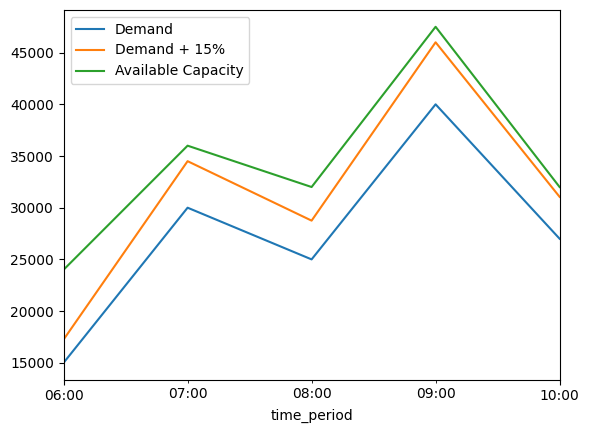

In [194]:
pd.DataFrame({
    "Demand": demand,
    "Demand + 15%": demand * 1.15,
    "Available Capacity": max_capacity_value,
}).plot.line()

In [195]:
# model.close()
# env.close()